In [1]:
%load_ext autoreload
%autoreload 2

from classification_models.tfkeras import Classifiers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.enable_eager_execution()

keras = tf.keras
K = tf.keras.backend

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import iic_datasets_ops
import iic_loss_ops
import utils
import models

In [16]:
batch_size = 256
image_size = 28
num_classes = 10
num_repeats = 5
input_shape = (28, 28, 1)
num_train_steps = 60000 // batch_size
num_eval_steps = 10000 // batch_size

In [3]:
train_dataset, dataset_info = tfds.load(name="mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
test_dataset = tfds.load(name="mnist", split=tfds.Split.TEST, as_supervised=True)

In [4]:
train_dataset

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [11]:
iic_train_dataset = iic_datasets_ops.prepare_training_dataset(train_dataset, num_image_repeats=num_repeats)

In [12]:
iic_train_iterator = iic_train_dataset.make_one_shot_iterator()

In [20]:
%timeit -n 10 next(iic_train_iterator)

The slowest run took 52.08 times longer than the fastest. This could mean that an intermediate result is being cached.
19.6 ms ± 9.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


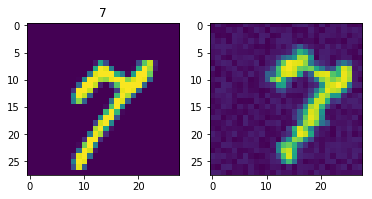

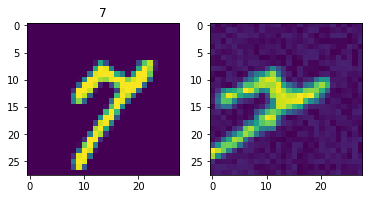

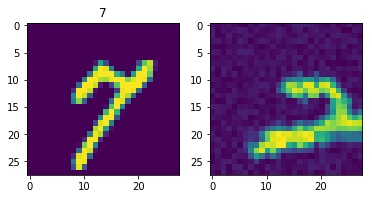

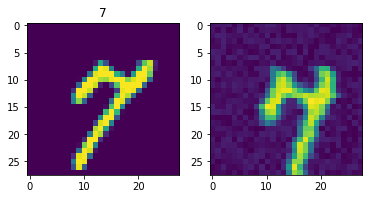

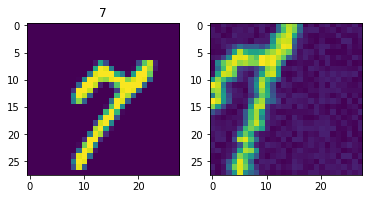

In [15]:
plotting_ops.plot_image_pairs(*next(iic_train_iterator), num_examples=5)

In [17]:
base_model = models.create_resnet_se_backbone(input_shape, (1, 1))

In [18]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 28, 28, 1)    3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 14, 14, 64)   3136        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [31]:
inputs, main_heads, aux_heads = models.create_iic_model(input_shape, base_model, main_head_num_classes=num_classes)

In [32]:
inputs, main_heads, aux_heads

({'image': <tf.Tensor 'image_4:0' shape=(?, 28, 28, 1) dtype=float32>,
  'tf_image': <tf.Tensor 'tf_image_4:0' shape=(?, 28, 28, 1) dtype=float32>},
 [{'outputs': [<tf.Tensor 'main_head_0/p_out_1/Identity:0' shape=(?, 10) dtype=float32>,
    <tf.Tensor 'main_head_0/p_tf_out_1/Identity:0' shape=(?, 10) dtype=float32>],
   'loss': <tf.Tensor 'main_head_0/iic_loss_1:0' shape=() dtype=float32>}],
 [])

In [120]:
p_out, p_tf_out = main_heads[0]['outputs']
iic_model = keras.Model(inputs=inputs, outputs={"p_out": p_out, "p_tf_out": p_tf_out})

In [121]:
iic_loss = iic_loss_ops.iic_loss(p_out, p_tf_out)

In [122]:
iic_model.add_loss(iic_loss)

In [123]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.995)
iic_model.compile(optimizer=optimizer)

W1019 23:23:00.443877 140283837552448 training_utils.py:1101] Output main_head_0/p_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to main_head_0/p_out.
W1019 23:23:00.444723 140283837552448 training_utils.py:1101] Output main_head_0/p_tf_out missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to main_head_0/p_tf_out.


In [124]:
# plotting_ops.plot_probabilities_grid(icc_model, iic_train_iterator)

In [125]:
prediction_hist = utils.PredictionsHistory(iic_train_iterator)
history = iic_model.fit(
    iic_train_iterator, verbose=1, epochs=3,
    steps_per_epoch=20, callbacks = [prediction_hist]
#     steps_per_epoch=num_train_steps,
)

Epoch 1/3
19/20 [===========================>..] - ETA: 1s - loss: -1.1625Classification error = 0.7656
error: 0.765625
20/20 [==============================] - 34s 2s/step - loss: -1.1620
Epoch 2/3
19/20 [===========================>..] - ETA: 0s - loss: -1.1934Classification error = 0.7578
error: 0.7578125
20/20 [==============================] - 14s 682ms/step - loss: -1.1904
Epoch 3/3
19/20 [===========================>..] - ETA: 0s - loss: -1.2023Classification error = 0.7500
error: 0.75
20/20 [==============================] - 13s 667ms/step - loss: -1.2026


Classification error = 0.7344


0.734375

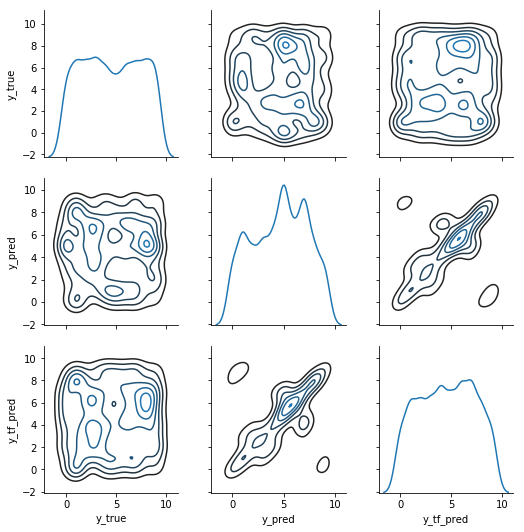

In [61]:
plotting_ops.plot_probabilities_grid(icc_model, iic_train_iterator)

In [63]:
features, labels = next(iic_train_iterator)

Classification error = 0.6406


0.640625

array([2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 7, 7,
       7, 7, 7, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 8,
       8, 8, 8, 8, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 4, 4, 4, 4,
       4, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 9,
       9, 9, 9, 9, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 6, 6, 6,
       6, 6, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 7, 7,
       7, 7, 7, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 7,